In [1]:
from qiskit_textbook.widgets import dj_widget
dj_widget(size="small", case="balanced")

HTMLMath(value='$$ |00\\rangle = |00\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x05\x00\x00\x00\xcc\x08\x06\x00\x00\x00z\x06\xb6…

In [2]:
import numpy as np

from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute

from qiskit.visualization import plot_histogram

### Implement: Constant Oracle

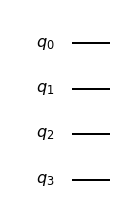

In [6]:
n_input = 3

const_oracle = QuantumCircuit(n_input+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n_input)

const_oracle.draw('mpl')

### Implement: Balanced Oracle

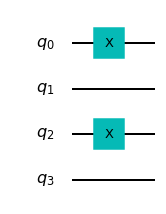

In [7]:
n_input = 3

balanced_oracle = QuantumCircuit(n_input+1)
b_str = "101"

for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw('mpl')

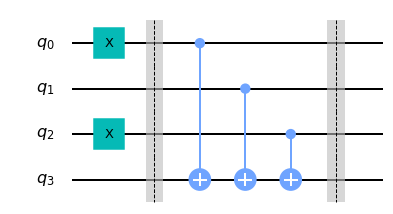

In [9]:
n_input = 3

balanced_oracle = QuantumCircuit(n_input+1)
b_str = "101"

for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle.barrier()

for qubit in range(n_input):
    balanced_oracle.cx(qubit, n_input)

balanced_oracle.barrier()
balanced_oracle.draw('mpl')

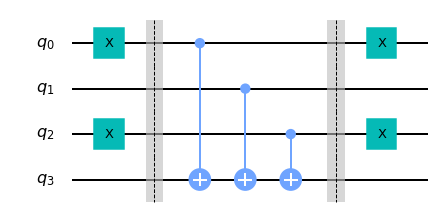

In [12]:
n_input = 3

balanced_oracle = QuantumCircuit(n_input+1)
b_str = "101"

for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle.barrier()

for qubit in range(n_input):
    balanced_oracle.cx(qubit, n_input)

balanced_oracle.barrier()

for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle.draw('mpl')

### Full Algorithm

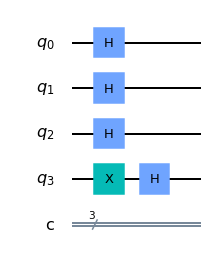

In [13]:
dj_circuit = QuantumCircuit(n_input+1, n_input)

for qubit in range(n_input):
    dj_circuit.h(qubit)

dj_circuit.x(n_input)
dj_circuit.h(n_input)
dj_circuit.draw('mpl')

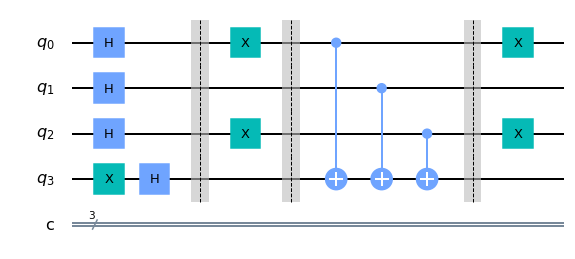

In [16]:
dj_circuit = QuantumCircuit(n_input+1, n_input)

for qubit in range(n_input):
    dj_circuit.h(qubit)

dj_circuit.x(n_input)
dj_circuit.h(n_input)
dj_circuit.barrier()

dj_circuit += balanced_oracle
dj_circuit.draw('mpl')

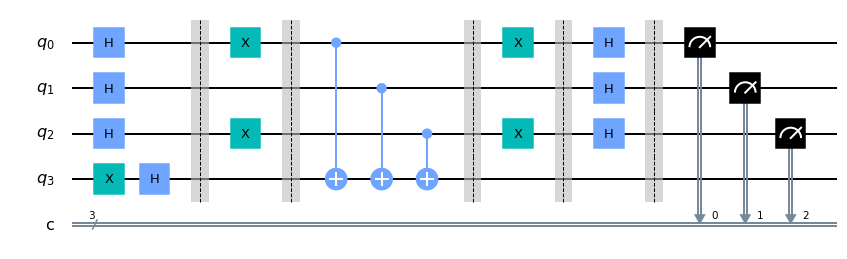

In [17]:
dj_circuit = QuantumCircuit(n_input+1, n_input)

for qubit in range(n_input):
    dj_circuit.h(qubit)

dj_circuit.x(n_input)
dj_circuit.h(n_input)
dj_circuit.barrier()

dj_circuit += balanced_oracle

dj_circuit.barrier()
for qubit in range(n_input):
    dj_circuit.h(qubit)
dj_circuit.barrier()

for i in range(n_input):
    dj_circuit.measure(i,i)

dj_circuit.draw('mpl')

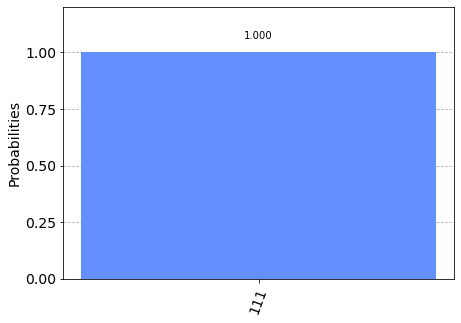

In [18]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(dj_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

## Generalised Circuits

In [22]:
def dj_oracle(case, n):
    oracle_qc = QuantumCircuit(n+1)
    
    if case == 'balanced':
        b = np.random.randint(1, 2**n)
        b_str = format(b, '0'+str(n)+'b')
        
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
    
    if case == 'constant':
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

In [23]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    
    dj_circuit.x(n)
    dj_circuit.h(n)
    
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    dj_circuit.append(oracle, range(n+1))
    
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i,i)
    
    return dj_circuit

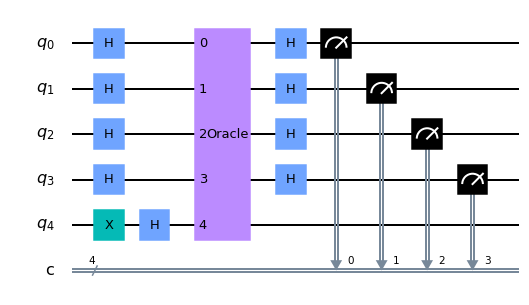

In [28]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw('mpl')

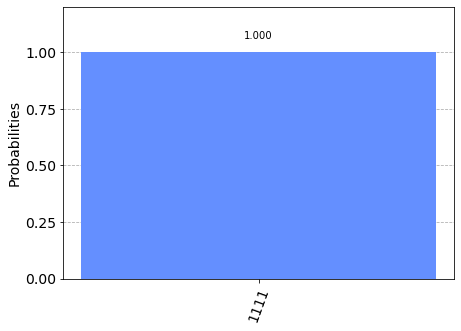

In [29]:
results = execute(dj_circuit, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

## Experiment with Real Device

In [31]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1)
                                      and not x.configuration().simulator
                                      and x.status().operational==True))
print("least busy backend", backend)

from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(dj_circuit, backend=backend, shots=shots, optimization_level=3)

job_monitor(job, interval = 2)

ibmqfactory.load_account:WARNING:2020-10-09 22:39:58,357: Credentials are already in use. The existing account in the session will be replaced.


least busy backend ibmqx2
Job Status: job has successfully run


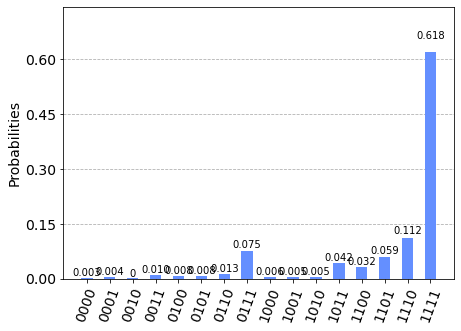

In [32]:
results = job.result()
answer = results.get_counts()

plot_histogram(answer)